# Ejemplo de Ozono

Considéremos los siguientes datos clásicos de Radiación Solar, Temperatura, Velocidad del Viento y 
Ozono para distintos días en Nueva York (@chambers83):

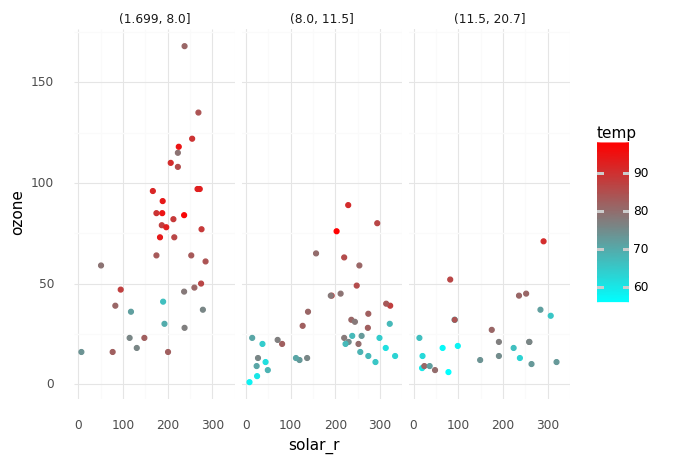

<ggplot: (-9223363290015264915)>

In [1]:
import numpy as np
import pandas as pd
from plotnine import *

airquality_raw = pd.read_csv("../datos/airquality_raw.csv")

air_data = (
    airquality_raw
        .rename(str.lower, axis='columns')
        .rename(columns={'solar.r': "solar_r"})
        .assign(wind_cat = pd.qcut(airquality_raw.Wind , 3))
        .where(airquality_raw.Ozone.notnull() & airquality_raw['Solar.R'].notnull())
        .dropna()
)
air = air_data.copy()

(ggplot(air, aes(x = 'solar_r', y = 'ozone',  colour = 'temp')) + 
     geom_point() +
     facet_wrap('~ wind_cat') +
     scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) +
     theme_minimal()
)

Esta una gráfica exploratoria útil,
qué nos permite entender estructura en los datos y hacer comparaciones útiles,
pero también sugiere qué podríamos intentar para predecir niveles de Ozono dependiendo de la resto
de las variables (Radiación Solar, Velocidad del viento y Temperatura).

 Podríamos estimar la media condicional
usando vecinos más cercanos. Conviene estandarizar las variables (convertirlas a la misma
escala) para que tenga más sentido calcular distancias. 

En este caso, usamos 27-vecinos más cercanos, y producimos 
predicciones para varios valores de velocidad del viento, temperatura
y radiación solar:

In [2]:
variables = [ 'wind', 'temp', 'solar_r']

pred_grid = (
    pd.DataFrame([(x, y, z) 
        for x in [5, 10, 15] 
        for y in np.arange( 60, 100, 10 ) 
        for z in np.arange( 20, 310, 10 )]
                )

)

pred_grid.columns = variables
pred_grid = pred_grid.sort_values(by =['solar_r', 'temp', 'wind'])

In [3]:
from sklearn.neighbors import KNeighborsRegressor

def ajustar_modelo(air, pred_grid, k = 27):
    
    variables = [ 'wind', 'temp', 'solar_r']
    
    air_medias = air[variables].mean()
    air_scale = air[variables].std()
    air_s = ( air[variables].copy() - air_medias ) / air_scale
    new_data_num = ( pred_grid[variables].copy() -  air_medias ) /  air_scale
    
    X_train = air_s
    y_train = air.ozone
    
    mod_knn = KNeighborsRegressor(n_neighbors = k)
    mod_knn.fit(X_train, y_train)

    X_test = new_data_num
    predicciones = mod_knn.predict(X_test)
    pred_grid['ozone'] = predicciones
    
    pred_grid_knn = pred_grid.copy()
    bins = pd.IntervalIndex.from_tuples([(1.699, 8.0), (8.0, 11.5), (11.5, 20.7)])
    pred_grid_knn['wind_cat'] =  pd.cut(pred_grid_knn.wind, bins)
    pred_grid_knn['int_temp_wind_cat'] = pred_grid_knn.temp.astype('str') + ":"+ pred_grid_knn.wind_cat.astype('str')
    
    return pred_grid_knn

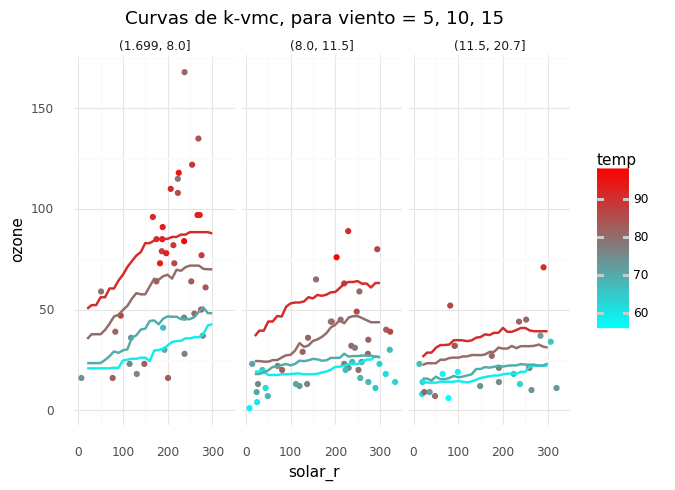

<ggplot: (-9223363290017504603)>

In [4]:
pred_grid_mod = ajustar_modelo(air, pred_grid, k = 27)

g_kvmc_1 = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mod, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Curvas de k-vmc, para viento = 5, 10, 15") +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) +
    theme_minimal()
)

g_kvmc_1

# Ejemplo: Ozono con sobre/subajuste

Si tomamos $k$ demasiado grande, nuestro modelo presenta poca variabilidad pero sesgos claros:

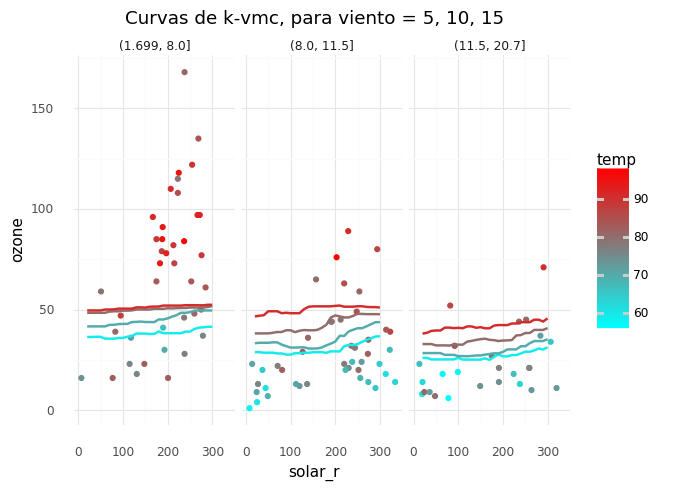

<ggplot: (8746835489982)>

In [5]:
pred_grid_mod = ajustar_modelo(air, pred_grid, k = 80)

g_kvmc_80 = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mod, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Curvas de k-vmc, para viento = 5, 10, 15") +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) +
    theme_minimal()
)

g_kvmc_80

Si tomamos $k$ demasiado chico, nuestro modelo presenta mucha variabilidad:

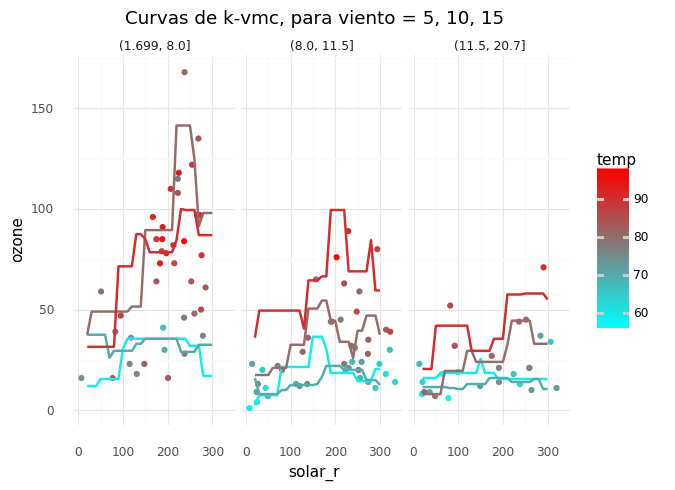

<ggplot: (8746835392923)>

In [6]:
pred_grid_mod = ajustar_modelo(air, pred_grid, k = 2)

g_kvmc_2 = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mod, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Curvas de k-vmc, para viento = 5, 10, 15") +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) +
    theme_minimal()
)

g_kvmc_2

Estos dos últimos modelos probablemente se desempeñarán
mal con respecto al que construimos con $k=27$ (podemos
usar una muestra de prueba para seleccionar el mejor de los modelos).


## Ejemplo: Mínimos cuadrados

Ajustamos primero un modelo lineal sin regularización:

In [7]:
air['temp_2'] = np.power(air.temp, 2)
air['wind_2'] = np.power(air.wind, 2)
air['solar_r_2'] = np.power(air.solar_r, 2)

air['temp_wind'] = air.temp * air.wind
air['solar_temp'] = air.solar_r * air.temp
air['wind_solar'] = air.wind * air.solar_r

pred_grid_mc = pred_grid.drop(columns = ['ozone'], axis = 1).copy()
pred_grid_mc['temp_2'] = np.power(pred_grid_mc.temp, 2)
pred_grid_mc['wind_2'] = np.power(pred_grid_mc.wind, 2)
pred_grid_mc['solar_r_2'] = np.power(pred_grid_mc.solar_r, 2)

pred_grid_mc['temp_wind'] = pred_grid_mc.temp * pred_grid.wind
pred_grid_mc['solar_temp'] = pred_grid_mc.solar_r * pred_grid_mc.temp
pred_grid_mc['wind_solar'] = pred_grid_mc.wind * pred_grid_mc.solar_r

bins = pd.IntervalIndex.from_tuples([(1.699, 8.0), (8.0, 11.5), (11.5, 20.7)])
pred_grid_mc['wind_cat'] =  pd.cut(pred_grid_mc.wind, bins)
pred_grid_mc['int_temp_wind_cat'] = pred_grid_mc.temp.astype('str') + ":"+ pred_grid_mc.wind_cat.astype('str')

X_train = air[['temp', 'temp_2', 'wind', 'wind_2', 'solar_r', 'solar_r_2','temp_wind', 'solar_temp', 'wind_solar']]
y_train = air.ozone

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
pred_grid_mc['ozone'] = lr.predict(pred_grid_mc[['temp', 'temp_2', 'wind', 'wind_2', 'solar_r', 'solar_r_2','temp_wind', 'solar_temp', 'wind_solar']])


Y examinamos las predicciones del modelo (líneas):

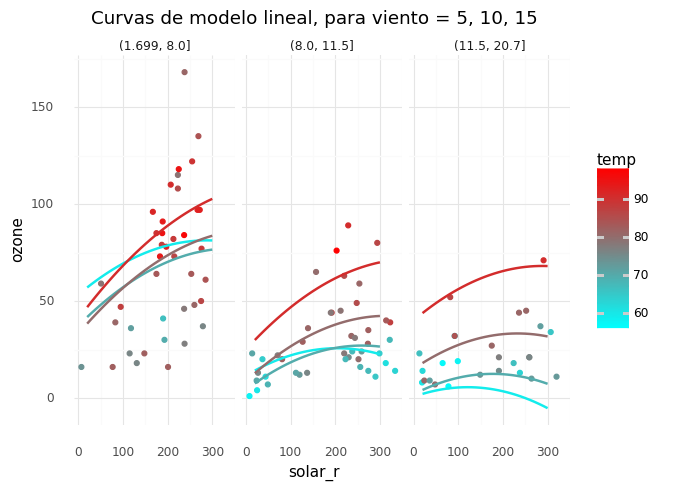

<ggplot: (-9223363290019363240)>

In [8]:
g_lineal = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mc, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Curvas de modelo lineal, para viento = 5, 10, 15") +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) +
    theme_minimal()
)
g_lineal


Nótese que algunos aspectos de este modelo parecen ser ruidosos: por ejemplo,
el comportamiento de las curvas para el primer pánel (donde hay pocos datos
de temperatura baja), el hecho de que en algunos casos parece haber 
curvaturas decrecientes e incluso predicciones negativas. No deberíamos poner mucho crédito en las predicciones
de este modelo, y tiene peligro de producir predicciones desastrosas.


## Regularización para ejemplo de Ozono {-}

En sklearn el parámetro de regularización es $\alpha$. Puedes checar la [documentación](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) para ver cómo se define alpha y compararlo con lo visto en clase en términos de $\lambda$. 

Utilizamos el modulo de linear_model.Ridge de sklearn para hacer regresión ridge. Usemos tres parametros de regularización y hacemos mínimos cuadrados regularizados. Tomamos $\alpha = 0.3$ y  $\alpha = 0.5$.

In [22]:
# https://stats.stackexchange.com/questions/160096/what-are-the-differences-between-ridge-regression-using-rs-glmnet-and-pythons

#lam = 1
#C = 1 / lam
#alpha = 1 / (2 * C)
#alpha

def reparametrizar_lambda_a_alpha(X, lam = 1):
    #N = X.shape[0] / 10
    #a = (lam * N) / 2
    C = 1 / lam
    alpha = 1 / (2 * C)
    return alpha 

def reparametrizar_alpha_a_lambda(X, alpha):
    #N = X.shape[0] / 10
    #lam = (2 / N) * alpha
    C = 1 / (alpha * 2)
    lam = 1 / C
    return lam

In [23]:
from sklearn.linear_model import Ridge
lam = 1
a = 0.5 #reparametrizar_lambda_a_alpha(X_train, lam)
lr_ridge = Ridge(alpha = a, fit_intercept = True, normalize = True )
lr_ridge.fit( X_train, y_train)
pred_grid_mc_reg_1 = pred_grid_mc.drop(columns = ['ozone'], axis = 1).copy()
pred_grid_mc_reg_1['ozone'] = lr_ridge.predict(pred_grid_mc_reg_1[['temp', 'temp_2', 'wind', 'wind_2', 'solar_r', 'solar_r_2','temp_wind', 'solar_temp', 'wind_solar']])

In [24]:
g_lineal_reg_1 = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mc_reg_1, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Lineal regularizado, alpha = 1.38879439e-11") +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) + 
    theme_minimal()
)

In [25]:
g_lineal_reg_1 = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mc_reg_1, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Lineal regularizado, alpha = " + str(a)) +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) + 
    theme_minimal()
)

In [26]:
a = 0.03

lr_ridge = Ridge(alpha = a, fit_intercept = True, normalize = True )
lr_ridge.fit( X_train, y_train)

pred_grid_mc_reg_2 = pred_grid_mc.drop(columns = ['ozone'], axis = 1).copy()
pred_grid_mc_reg_2['ozone'] = lr_ridge.predict(pred_grid_mc_reg_2[['temp', 'temp_2', 'wind', 'wind_2', 'solar_r', 'solar_r_2','temp_wind', 'solar_temp', 'wind_solar']])

g_lineal_reg_2 = (
    ggplot(air, aes(x = 'solar_r', y = 'ozone', colour = 'temp')) + 
    geom_point() +
    facet_wrap('~ wind_cat') +
    geom_line(pred_grid_mc_reg_2, aes(y = 'ozone', group = 'int_temp_wind_cat'), size = 1) +
    labs(title = "Lineal regularizado, alpha = " + str(a)) +
    scale_color_gradientn(colors = ["#00FFFFFF", "#FF0000FF"]) +
    theme_minimal()
)

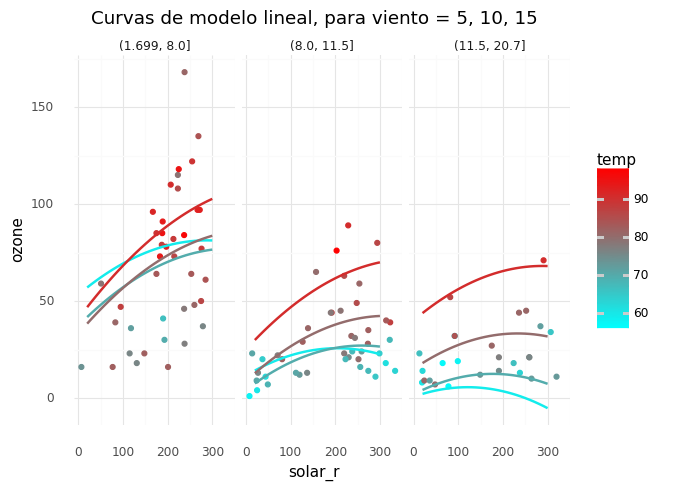

<ggplot: (-9223363290019363240)>

In [27]:
g_lineal

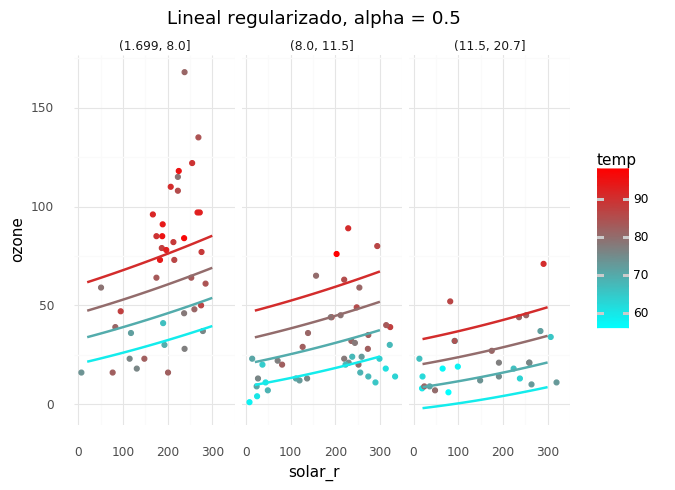

<ggplot: (8746830672609)>

In [28]:
g_lineal_reg_1

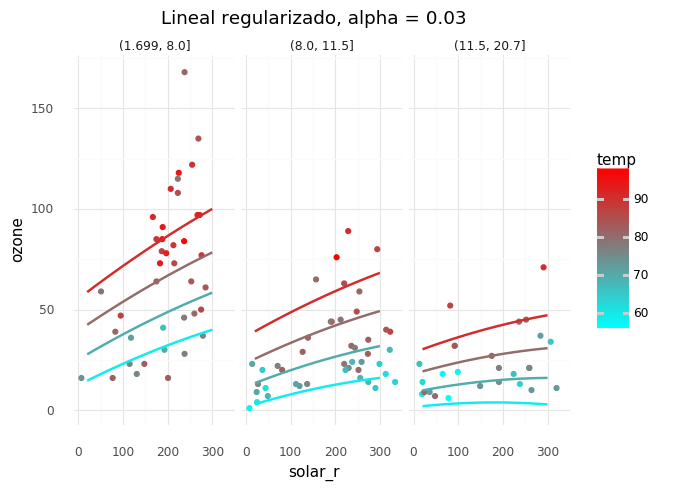

<ggplot: (-9223363290019374830)>

In [29]:
g_lineal_reg_2

¿Qué modelo crees que se desempeñe mejor? ¿Cuál va a producir mejores comparaciones predictivas?

## ¿Cómo seleccionar los hiperparámetros? {-}

Los hiperparámetros en este caso son valores que establecemos para hacer
el ajuste del modelo particular después. En el ejemplo de $k$ vecinos más
cercanos, $k$ es el único hiperparámetro, y en regresión regularizada
$\lambda$ ($\alpha$ en sklearn) es el único hiperparámetro. 

La manera más simple es la siguiente: si tenemos un conjunto de datos grande,
los dividimos en tres partes al azar,

- Entrenamiento (50\%)
- Validación (25\%)
- Prueba (25\%)

1. Ajustamos varios modelos con distintos grados de regularización (por ejemplo $\lambda$)
2. Seleccionamos la $\alpha$ que da mejor el error en la muestra de validación
3. Repetimos 1-2 con otras familias de modelos (por ejemplo k-vecinos más cercanos)
4. Probamos un número chico de modelos con la muestra de prueba para obtener estimaciones
finales de su error de predicción.

Esta división en 3 partes nos protege de "sobreajustar" cuando hacemos iteraciones
entrenamiento-validación. Al final siempre tenemos una estimación "honesta" del 
desempeño predictivo.

**Observación**: en algunos casos, tenemos que ser cuidadosos con cómo separamos
las muestras de entrenamiento y validación/prueba. Idealmente, queremos 
que **esta separación refleje en lo posible la manera en que las predicciones van
a ser producidas**. Por ejemplo: 

- Si los datos de entrenamiento son caras repetidas
de varias personas (por ejempo, 20 caras para cada una de 500 personas), y queremos crear un clasificador de caras, entonces tendremos cuidado de seleccionar
dividir al azar las *personas*, no las *caras* individuales. 
- Si queremos hacer pronósticos para cantidad de series de tiempo, tendremos cuidado en que las observaciones de validación y prueba están son posteriores a los datos de entrenamiento.


## Ejemplo: selección del parámetro  $\alpha$ de regularización

En sklearn el parámetro de regularización es $\alpha$. En nuestro caso de mediciones de Ozono, si tuviéramos una muestra de validacion tomaríamos varias $\alpha$ y ajustaríamos un modelo para cada una de ellas. Escogemos la $\alpha$ que nos da el menor error de validación:

In [30]:
from sklearn.model_selection import GridSearchCV
lr_ridge = Ridge( fit_intercept = True, normalize = True )

hiperparams_rejilla = hiperparams_rejilla = {
    'alpha': reparametrizar_lambda_a_alpha(X_train, np.exp( np.arange( -6, 2, 0.05)  ))
}

busqueda_grid = GridSearchCV( lr_ridge, hiperparams_rejilla, scoring = 'neg_mean_squared_error', 
                               cv = 10, n_jobs = -1 )
busqueda_grid = busqueda_grid.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
resultados_cv = pd.DataFrame(busqueda_grid.cv_results_)
busqueda_grid.best_params_

{'alpha': 0.02751161002820331}

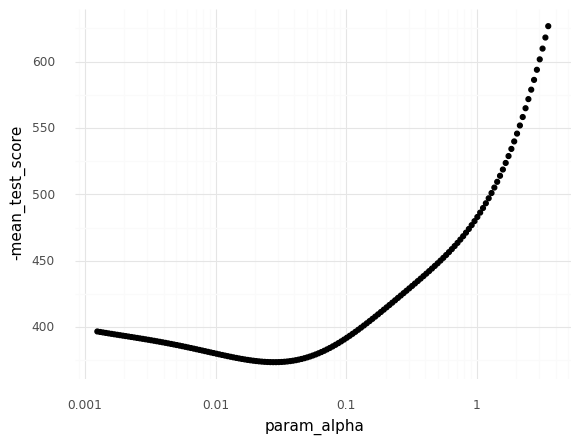

<ggplot: (8746835476607)>

In [32]:
(
    ggplot(resultados_cv, aes(x = 'param_alpha', y = '-mean_test_score')) + 
    geom_point() + 
    scale_x_log10() +
    theme_minimal()
)

## Métodos de predicción y la maldición de la dimensionalidad

Notamos en primer lugar que en el problema de Ozono, los modelos seleccionados para k-vmc y regresión regularizada tienen predicciones simillares:

En segundo lugar, observamos que k-vecinos más cercanos es un método intuitivo y simple
(aunque quizá no tan computacionalmente conveniente), y que intenta estimar
directamente la cantidad de interés: la media condicional de las $y$ dada las $x$.

Entonces Ingenuamente podríamos preguntarnos ¿por qué tantos métodos? ¿por qué construir predicciones de alguna otra
manera que $k$-vecinos más cercanos, que estima directamente la cantidad de interés?
Y más aún: si tengo grandes cantidades de datos, este método debe funcionar muy bien, pues puedo usar promedios
a lo largo de varias variables que incluyan muchas observaciones. 

Y en parte esto es cierto para problemas de dimensión baja (digamos, 2,3 o 4 variables). El problema
es que generalmente nuestros problemas son de dimensionalidad más alta.

- Cuando la dimensión es no muy chica, todos los datos de entrenamiento tienden a ser *ralos*,
lo que quiere decir que todos los puntos están lejanos unos de otros. 
- Si la dimensión es alta, entonces no hay manera de evitar uno de dos problemas: o tomamos muchos vecinos,
y entonces las predicciones son extrapolaciones graves, o tomamos muy pocos, y nuestro modelo es poco confiable
y tiene alta variabilidad. Peor aún, aunque tomemos un vecino más cercano seguimos extrapolando gravemente.

Esto es contraintuitivo en un principio.

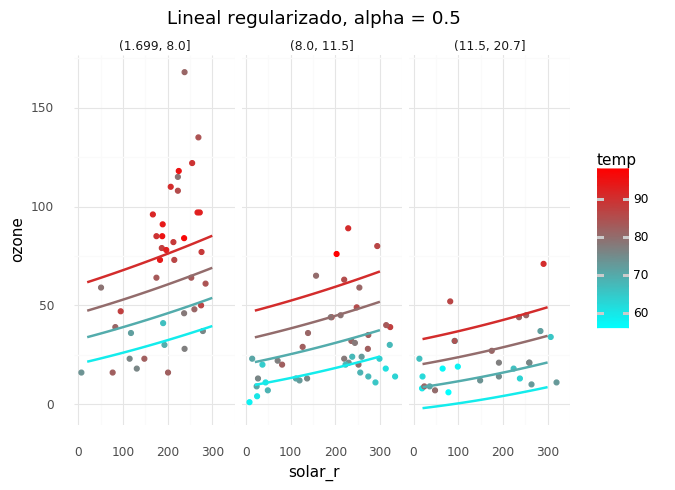

<ggplot: (8746830672609)>

In [33]:
g_lineal_reg_1

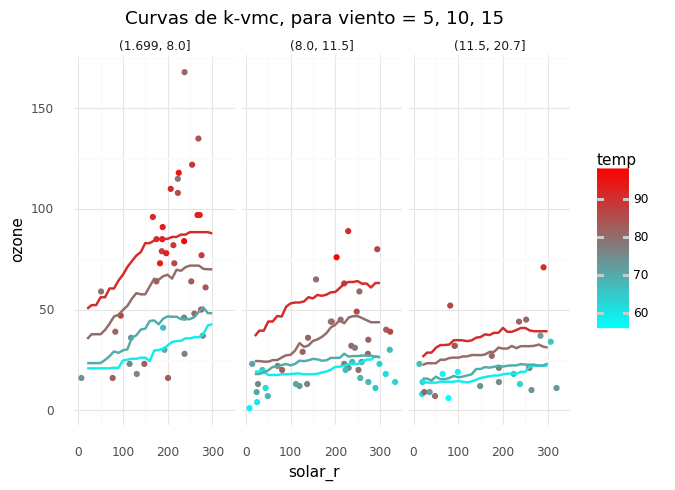

<ggplot: (-9223363290017504603)>

In [34]:
g_kvmc_1